In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import pandas as pd
import time
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [2]:
data = pd.read_csv('data_map_stops_final.csv')

In [3]:
data.dropna(inplace=True)

### Eliminating some labels

In [4]:
data = data[(data['label'] != 'init_trip') & (data['label']!='end_trip')]

### Splitting data

In [5]:
X = data[['lat','lng','velocidade','acc','delta_time','delta_space','matricula_id','week_days','hours','months']].values
y = data[['label']].values

### Plotting labels distributions

In [6]:
def bar_plot(x,y):
    fig, ax = plt.subplots()
    plt.bar(np.arange(len(x)),x)
    plt.xticks(np.arange(len(x)), ('bus_stop', 'in_route', 'other_stop', 'traffic_light'))
    plt.show()


In [7]:
bus_stop = len(data[data['label']=='bus_stop'])
in_route = len(data[data['label']=='in_route'])
other_stop = len(data[data['label']=='other_stop'])
traffic_light = len(data[data['label']=='traffic_light'])

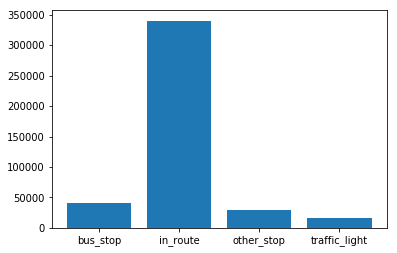

In [8]:
bar_plot([bus_stop,in_route,other_stop,traffic_light],np.unique(y).tolist())

### Enconding categorical variable
<p> Those variables 

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [10]:
lb = LabelEncoder()
X[:,6] = lb.fit_transform(X[:,6])
X[:,7] = lb.fit_transform(X[:,7])
X[:,8] = lb.fit_transform(X[:,8])
X[:,9] = lb.fit_transform(X[:,9])

In [11]:
np.unique(X[:,6]),np.unique(X[:,7]), np.unique(X[:,8]),np.unique(X[:,9])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52],
       dtype=object),
 array([0, 1, 2, 3, 4, 5, 6], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23], dtype=object),
 array([0, 1], dtype=object))

In [12]:
le = LabelEncoder()
y = le.fit_transform(y)

/home/mobility/anaconda/envs/michael_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
np.unique(y)

array([0, 1, 2, 3])

### Splitting in train and test

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)

### Batch function

In [15]:
def get_batches(x, y, batch_size, n_steps):
    '''Create a generator that returns batches of size
       batch_size x n_steps from arr.
       
       Arguments
       ---------
       x: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    # Get the number of characters per batch and number of batches we can make
    characters_per_batch = batch_size*n_steps
    n_batches = len(x)//characters_per_batch
    # Keep only enough characters to make full batches
    x= x[:characters_per_batch*n_batches]
    y= y[:characters_per_batch*n_batches]
    
    # Reshape into batch_size rows
    x= x.reshape((-1,n_steps,10))
    y= y.reshape((-1,n_steps))
    for n in range(0, x.shape[0], batch_size):
        # The features
        x1 = x[n:n+batch_size]
        # The targets, shifted by one
        y1 = y[n:n+batch_size]
        
        yield x1, y1

In [16]:
a = get_batches(X_train,y_train, 10, 50)

In [17]:
len(X_train),len(y_train)

(341793, 341793)

In [18]:
a,b = next(a)

### Building LSTM

In [19]:
def build_inputs(batch_size, num_steps, features_numeric, features_discrete):
    ''' Define placeholders for inputs, targets, and dropout 
    
        Arguments
        ---------
        batch_size: Batch size, number of sequences per batch
        num_steps: Number of sequence steps in a batch
        features: Number of features in batch
        
    '''
    # Declare placeholders we'll feed into the graph
    inputs = tf.placeholder(tf.float32, [batch_size, num_steps, features_numeric], name='inputs_numeric')
    inputs_id = tf.placeholder(tf.int32, [batch_size, num_steps, features_discrete], name='inputs_id') 
    inputs_m = tf.placeholder(tf.int32, [batch_size, num_steps, features_discrete], name='inputs_month')
    inputs_w = tf.placeholder(tf.int32, [batch_size, num_steps, features_discrete], name='inputs_week')
    inputs_h = tf.placeholder(tf.int32, [batch_size, num_steps, features_discrete], name='inputs_hour')
    targets = tf.placeholder(tf.int32, [batch_size, num_steps], name='targets')
    
    # Keep probability placeholder for drop out layers
    keep_prob = tf.placeholder(tf.float32)
    
    return inputs,inputs_id,inputs_m, inputs_w, inputs_h, targets, keep_prob

In [20]:
def build_input_summaries():
    tf_loss = tf.placeholder(tf.float32, shape=None, name='loss_summary')
    tf_loss_summary = tf.summary.scalar('loss', tf_loss)

In [21]:
def build_embeddings(n_vocab,n_embedding,inputs, name):
    with tf.variable_scope('embeddings'):
        embedding = tf.Variable(tf.random_uniform((n_vocab,n_embedding),-1,1), name=name)
        embed = tf.nn.embedding_lookup(embedding, inputs)
    return embed

In [22]:
def build_lstm(lstm_size, num_layers, batch_size, keep_prob):
    ''' Build LSTM cell.
    
        Arguments
        ---------
        keep_prob: Scalar tensor (tf.placeholder) for the dropout keep probability
        lstm_size: Size of the hidden layers in the LSTM cells
        num_layers: Number of LSTM layers
        batch_size: Batch size

    '''
    ### Build the LSTM Cell
    # Use a basic LSTM cell
    def build_cell(lstm_size, keep_prob):
        # Use a basic LSTM cell
        lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

        # Add dropout to the cell
        drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
        return drop
    
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([build_cell(lstm_size, keep_prob) for _ in range(num_layers)])
    initial_state = cell.zero_state(batch_size, tf.float32)

    
    return cell, initial_state

In [23]:
def build_output(lstm_output, in_size, out_size,embed_id, embed_m, embed_w, embed_h):
    ''' Build a softmax layer, return the softmax output and logits.
    
        Arguments
        ---------
        
        lstm_output: List of output tensors from the LSTM layer
        in_size: Size of the input tensor, for example, size of the LSTM cells
        out_size: Size of this softmax layer
    
    '''

    # Reshape output so it's a bunch of rows, one row for each step for each sequence.
    # Concatenate lstm_output over axis 1 (the columns)
    seq_output = tf.concat(lstm_output, axis=1)
    # Reshape seq_output to a 2D tensor with lstm_size columns
    # -1 porque ele preenche a quantidade de linhas de automaticamente, apenas fixa as colunas
    x = tf.reshape(seq_output,[-1,in_size])
    
    x = tf.concat([x, tf.reshape(embed_id,[-1,10]),tf.reshape(embed_m,[-1,10]), tf.reshape(embed_w,[-1,10]), tf.reshape(embed_h,[-1,10])],1)
    print(x)
    # Connect the RNN outputs to a softmax layer
    with tf.variable_scope('softmax'):
        # Create the weight and bias variables here
        softmax_w = tf.Variable(tf.truncated_normal((in_size+40,out_size),stddev=0.1))
        softmax_b = tf.Variable(tf.zeros(out_size))
    
    tf.summary.histogram('softmax_w', softmax_w)
    # Since output is a bunch of rows of RNN cell outputs, logits will be a bunch
    # of rows of logit outputs, one for each step and sequence
    logits = tf.add(tf.matmul(x,softmax_w), softmax_b)
    
    # Use softmax to get the probabilities for predicted characters
    out = tf.nn.softmax(logits=logits)
    
    return out, logits

In [24]:
def build_loss(logits, targets,num_classes):
    ''' Calculate the loss from the logits and the targets.
    
        Arguments
        ---------
        logits: Logits from final fully connected layer
        targets: Targets for supervised learning
        lstm_size: Number of LSTM hidden units
        num_classes: Number of classes in targets
        
    '''
    
    # One-hot encode targets and reshape to match logits, one row per sequence per step
    y_one_hot = tf.one_hot(targets,num_classes)
    y_reshaped =  tf.reshape(y_one_hot,logits.get_shape())
    
    # Softmax cross entropy loss
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_reshaped, logits=logits)
    loss = tf.reduce_mean(loss)
    return loss

In [25]:
def build_optimizer(loss, learning_rate, grad_clip):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

In [26]:
class MobilityRNN:
    
    def __init__(self, num_classes=4, batch_size=64, num_steps=50, 
                       lstm_size=128, num_layers=2, learning_rate=0.001, 
                       grad_clip=5, sampling=False, features1=6, features2=1):
    
        # When we're using this network for sampling later, we'll be passing in
        # one character at a time, so providing an option for that
#         if sampling == True:
#             batch_size, num_steps = 1, 1
#         else:
        batch_size, num_steps = batch_size, num_steps

        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs, self.inputs_id, self.inputs_m, self.inputs_w, self.inputs_h, self.targets, self.keep_prob = build_inputs(batch_size,num_steps,features1,features2)
                
        self.embed_id = build_embeddings(53,10,self.inputs_id,'matricula_id')
        self.embed_m = build_embeddings(2,10,self.inputs_m,'month')
        self.embed_w = build_embeddings(7,10,self.inputs_w,'week')
        self.embed_h = build_embeddings(24,10,self.inputs_h,'hour')
        
        # Build the LSTM cell
        cell, self.initial_state = build_lstm(lstm_size,num_layers,batch_size,self.keep_prob)

        # Run each sequence step through the RNN with tf.nn.dynamic_rnn 
        outputs, state =tf.nn.dynamic_rnn(cell, self.inputs, initial_state=self.initial_state)
        self.final_state = state
        
        # Get softmax predictions and logits
        self.prediction, self.logits = build_output(outputs,lstm_size,num_classes,self.embed_id,self.embed_m, self.embed_w, self.embed_h)

        tf.summary.histogram("predictions", self.prediction)
        
        # Loss and optimizer (with gradient clipping)
        self.loss =  build_loss(self.logits,self.targets,num_classes)
        self.optimizer = build_optimizer(self.loss, learning_rate, grad_clip)

In [27]:
24*8*0.25

48.0

### Training the model

In [28]:
batch_size = 10         # Sequences per batch
num_steps = 10          # Number of sequence steps per batch
lstm_size = 64         # Size of hidden layers in LSTMs
num_layers = 1         # Number of LSTM layers
learning_rate = 0.001    # Learning rate
keep_prob = 0.5         # Dropout keep probability

In [26]:
epochs = 2
# Print losses every N interations
print_every_n = 50

# Save every N iterations
save_every_n = 200

model = MobilityRNN(4, batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, num_layers=num_layers, 
                learning_rate=learning_rate)

if not os.path.exists('summaries'):
    os.mkdir('summaries')
if not os.path.exists(os.path.join('summaries','first')):
    os.mkdir(os.path.join('summaries','first'))
    
saver = tf.train.Saver(max_to_keep=100)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    summ_writer = tf.summary.FileWriter(os.path.join('summaries','first'), sess.graph)
#     # Use the line below to load a checkpoint and resume training
#     #saver.restore(sess, 'checkpoints/______.ckpt')
    counter = 0
    for e in range(epochs):
#         # Train network
        new_state = sess.run(model.initial_state)
        loss = 0
        batch_loss_per_epoch = list()
        for x1, y1 in get_batches(X_train,y_train, batch_size, num_steps):
            counter += 1
            start = time.time()
            feed = {model.inputs: x1[:,:,:6],
                    model.inputs_id: x1[:,:,6].reshape(10,10,1),
                    model.inputs_m: x1[:,:,-1].reshape(10,10,1),
                    model.inputs_h: x1[:,:,7].reshape(10,10,1),
                    model.inputs_w: x1[:,:,8].reshape(10,10,1),
                    model.targets: y1,
                    model.keep_prob: keep_prob,
                    model.initial_state: new_state}

            merge = tf.summary.merge_all()
            
            summary,batch_loss, new_state, _ = sess.run([merge,model.loss, 
                                                 model.final_state, 
                                                 model.optimizer], 
                                                 feed_dict=feed)
            
            summ_writer.add_summary(summary, counter)
            
            batch_loss_per_epoch.append(batch_loss)
            if (counter % print_every_n == 0):
                end = time.time()
                print('Epoch: {}/{}... '.format(e+1, epochs),
                      'Training Step: {}... '.format(counter),
                      'Training loss: {:.4f}... '.format(batch_loss),
                      '{:.4f} sec/batch'.format((end-start)))
        
            if (counter % save_every_n == 0):
                saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))
        
    saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))

Tensor("concat_1:0", shape=(100, 104), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch: 1/2...  Training Step: 50...  Training loss: 0.7423...  0.4363 sec/batch
Epoch: 1/2...  Training Step: 100...  Training loss: 0.4311...  0.5119 sec/batch
Epoch: 1/2...  Training Step: 150...  Training loss: 0.3510...  0.4619 sec/batch
Epoch: 1/2...  Training Step: 200...  Training loss: 0.4663...  0.5473 sec/batch
Epoch: 1/2...  Training Step: 250...  Training loss: 0.3094...  0.4753 sec/batch
Epoch: 1/2...  Training Step: 300...  Training loss: 0.3636...  0.5368 sec/batch
Epoch: 1/2...  Training Step: 350...  Training loss: 0.3640...  0.3869 sec/batch
Epoch: 1/2...  Training Step: 400...  Training loss: 0.2662...  0.5808 sec/batch
Epoch: 1/2...  Training Step: 450...  Training loss: 0.2505...  0.7450 sec/batch
Epoch: 1/2...  Training Step:

Epoch: 2/2...  Training Step: 4800...  Training loss: 0.1413...  1.6561 sec/batch
Epoch: 2/2...  Training Step: 4850...  Training loss: 0.2338...  1.3958 sec/batch
Epoch: 2/2...  Training Step: 4900...  Training loss: 0.2830...  1.7119 sec/batch
Epoch: 2/2...  Training Step: 4950...  Training loss: 0.3377...  2.0090 sec/batch
Epoch: 2/2...  Training Step: 5000...  Training loss: 0.2676...  1.5489 sec/batch
Epoch: 2/2...  Training Step: 5050...  Training loss: 0.2968...  1.8679 sec/batch
Epoch: 2/2...  Training Step: 5100...  Training loss: 0.2399...  1.9309 sec/batch
Epoch: 2/2...  Training Step: 5150...  Training loss: 0.2431...  1.7292 sec/batch
Epoch: 2/2...  Training Step: 5200...  Training loss: 0.2773...  1.3986 sec/batch
Epoch: 2/2...  Training Step: 5250...  Training loss: 0.2599...  1.6333 sec/batch
Epoch: 2/2...  Training Step: 5300...  Training loss: 0.2567...  1.2698 sec/batch
Epoch: 2/2...  Training Step: 5350...  Training loss: 0.2095...  1.3624 sec/batch
Epoch: 2/2...  T

In [29]:
tf.train.get_checkpoint_state('checkpoints')

model_checkpoint_path: "checkpoints/i6834_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i200_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i400_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i600_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i800_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i1000_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i1200_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i1400_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i1600_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i1800_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i2000_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i2200_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i2400_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i2600_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i2800_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i3000_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/i3200_l64.ckpt"
all_model_checkpoint_paths: "checkpoints

### Testing the model

In [30]:
def sample(checkpoint,lstm_size):
    model = MobilityRNN(4,batch_size=10, num_steps=10 ,lstm_size=lstm_size,num_layers=1, sampling=True)
    saver = tf.train.Saver()
    predictions = list()
    labels_list = list()
    with tf.Session() as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state)
        for x1,y1 in get_batches(X_test,y_test,10,10):
            feed = {model.inputs: x1[:,:,:6],
                    model.inputs_id: x1[:,:,6].reshape(10,10,1),
                    model.inputs_m: x1[:,:,-1].reshape(10,10,1),
                    model.inputs_h: x1[:,:,7].reshape(10,10,1),
                    model.inputs_w: x1[:,:,8].reshape(10,10,1),
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)
            predictions.append(preds)
            labels_list.append(y1)
    return predictions, labels_list

In [31]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
samp, y_test_batches = sample(checkpoint,lstm_size)

Tensor("concat_1:0", shape=(100, 104), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

INFO:tensorflow:Restoring parameters from checkpoints/i6834_l64.ckpt


In [57]:
import warnings
warnings.filterwarnings("ignore")
def inverse_transform(data, batch=False, reshape=100):
    classes = list()
    for items in data:
        if not batch:
            label_idx = np.argmax(items, axis=1).tolist()
            list_inverse = list(le.inverse_transform(label_idx))
            classes += list_inverse
        else:
            classes += list(le.inverse_transform(items.reshape(reshape,)))
    return classes
predict = inverse_transform(samp)
y_test_transformed = inverse_transform(y_test_batches,True)

In [58]:
len(predict),len(y_test_transformed)

(85400, 85400)

In [61]:
matrix = confusion_matrix(y_test_transformed,predict)

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 6258  1207   757   118]
 [  731 65023  2053    92]
 [  510  1528  3924    73]
 [ 1714   749   467   196]]


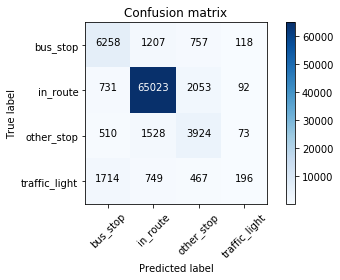

In [64]:
plot_confusion_matrix(matrix,np.unique(y_test_transformed))